<h1>Relatório da Disciplina EEL891 - Introdução ao Aprendizado de Máquina</h1>
Aluno: João Felipe Guedes da Silva
Período: 2018.2

## 1. Imports

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import norm, skew

## 2. Carregando o dataset

In [2]:
dataset_dir = './Dataset/'
train_set = pd.read_csv(dataset_dir + 'train.csv')
test_set = pd.read_csv(dataset_dir + 'test.csv')

In [3]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4683 entries, 0 to 4682
Data columns (total 21 columns):
Id                4683 non-null int64
tipo              4683 non-null object
bairro            4683 non-null object
tipo_vendedor     4683 non-null object
quartos           4683 non-null int64
suites            4683 non-null int64
vagas             4683 non-null int64
area_util         4683 non-null int64
area_extra        4683 non-null int64
diferenciais      4683 non-null object
churrasqueira     4683 non-null int64
estacionamento    4683 non-null int64
piscina           4683 non-null int64
playground        4683 non-null int64
quadra            4683 non-null int64
s_festas          4683 non-null int64
s_jogos           4683 non-null int64
s_ginastica       4683 non-null int64
sauna             4683 non-null int64
vista_mar         4683 non-null int64
preco             4683 non-null float64
dtypes: float64(1), int64(16), object(4)
memory usage: 768.4+ KB


In [4]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
Id                2000 non-null int64
tipo              2000 non-null object
bairro            2000 non-null object
tipo_vendedor     2000 non-null object
quartos           2000 non-null int64
suites            2000 non-null int64
vagas             2000 non-null int64
area_util         2000 non-null int64
area_extra        2000 non-null int64
diferenciais      2000 non-null object
churrasqueira     2000 non-null int64
estacionamento    2000 non-null int64
piscina           2000 non-null int64
playground        2000 non-null int64
quadra            2000 non-null int64
s_festas          2000 non-null int64
s_jogos           2000 non-null int64
s_ginastica       2000 non-null int64
sauna             2000 non-null int64
vista_mar         2000 non-null int64
dtypes: int64(16), object(4)
memory usage: 312.6+ KB


## 3. Pre-processamento

O dataset não possui valores faltantes e, portanto, tal etapa não será realizada. 

Ao todo, o dataset possui 21 variáveis, das quais podem ser separadas em:
- 4 Variáveis de entrada categóricas: tipo, bairro, tipo_vendedor, diferenciais
- 5 Variáveis de entrada numéricas não-binárias: quartos, suites, vagas, area_util, area_extra
- 10 Variáveis de entrada numéricas binárias: churrasqueira, estacionamento, piscina, playground, quadra, s_festas, s_jogos, s_ginastica, sauna, vista_mar
- 1 Variável de saída numérica: preco

A variável **Id** não possui valor quantitativo para o problema por se tratar de um identificador e, portanto, será continuamente removida das análises. 

O pré-processamento de cada um dos conjuntos de variáveis será realizado separadamente.


In [5]:
print ('Train shape: ', train_set.shape)
print ('Test shape: ', test_set.shape)

Train shape:  (4683, 21)
Test shape:  (2000, 20)


### 3.0 Transformação Variável Saída

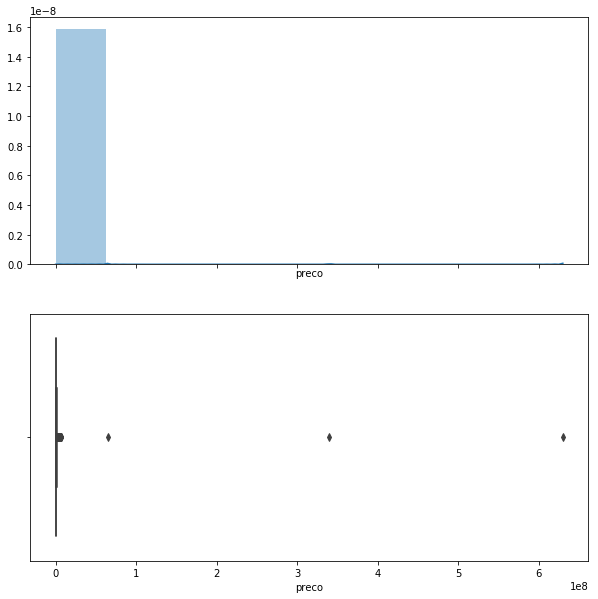

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
sns.distplot(train_set['preco'], bins = 10, ax = axes[0])
sns.boxplot(x = train_set['preco'], ax = axes[1])

In [7]:
preco_thr = 2*np.power(10, 6)
train_set = train_set[train_set['preco'] < preco_thr]

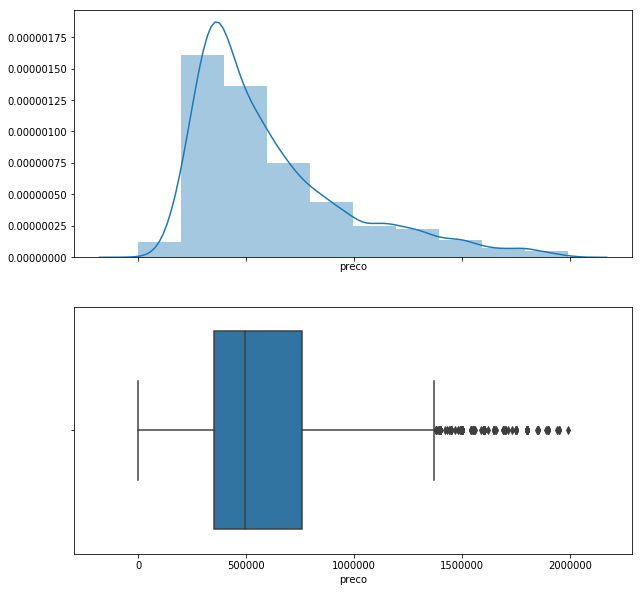

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
sns.distplot(train_set['preco'], bins = 10, ax = axes[0])
sns.boxplot(x = train_set['preco'], ax = axes[1])

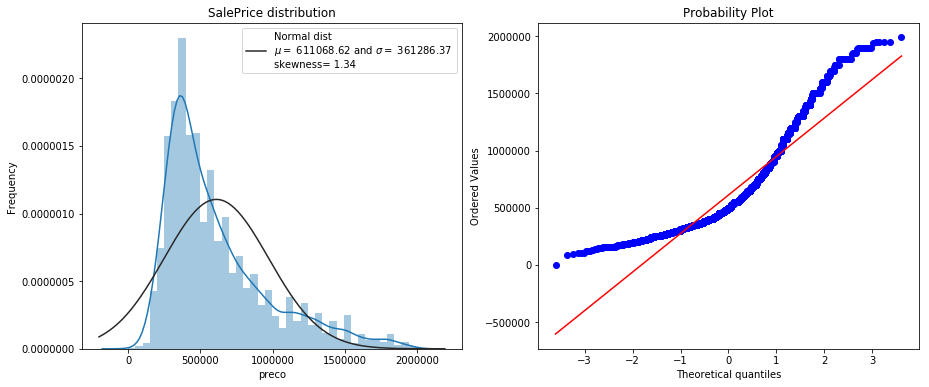

In [9]:
from scipy import stats
from scipy.stats import norm, skew

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.distplot(train_set['preco'], fit = norm, ax = axes[0]);
(mu, sigma) = norm.fit(train_set['preco'])

axes[0].legend(['Normal dist \n$\mu=$ {:.2f} and $\sigma=$ {:.2f} \nskewness= {:.2f}'
                                    .format(mu, sigma, skew(train_set['preco']))],
                loc='best')
axes[0].set_ylabel('Frequency')
axes[0].set_title('SalePrice distribution')

stats.probplot(train_set['preco'], plot = axes[1])
plt.show()

Podemos perceber que a variável alvo não se aproxima da distribuição normal, e tem uma cauda longa para a direita. É recomendável realizar uma transformação nos dados para aproximá-los de uma gaussiana, o que costuma melhorar a performance dos modelos. Para isso, será utilizada a transformação logp1. Como o desafio no kaggle avalia o RMSLE, ao realizar esta transformação na saída, podemos avaliar os modelos utilizando o RMSE como métrica de erro, sem se preocupar em fazer a transformação inversa da variável, a parcela log já foi aplicada.

In [10]:
train_set['preco'] = np.log1p(train_set['preco'])

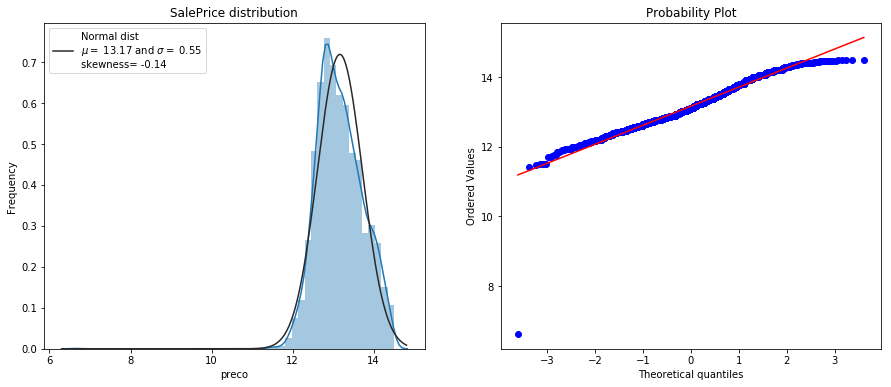

In [11]:

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.distplot(train_set['preco'], fit = norm, ax = axes[0]);

(mu, sigma) = norm.fit(train_set['preco'])
axes[0].legend(['Normal dist \n$\mu=$ {:.2f} and $\sigma=$ {:.2f}\nskewness= {:.2f}'
                                                .format(mu, sigma, skew(train_set['preco']))],
               loc='best')
axes[0].set_ylabel('Frequency')
axes[0].set_title('SalePrice distribution')

res = stats.probplot(train_set['preco'], plot = axes[1])
plt.show()

In [12]:
print ('Train shape: ', train_set.shape)
print ('Test shape: ', test_set.shape)

Train shape:  (4484, 21)
Test shape:  (2000, 20)


### 3.1 Transformação de variável categórica em numérica

#### 3.1.1 Tipo
Como a quantidade de ocorrências dos tipos Apartamento e Casa são muito maiores do que Quitinete e Loft, esta variável será transformada em uma variável binária onde **1** é o tipo apartamento e **0** é o tipo não-apartamento (Casa, Quitinete ou Loft)

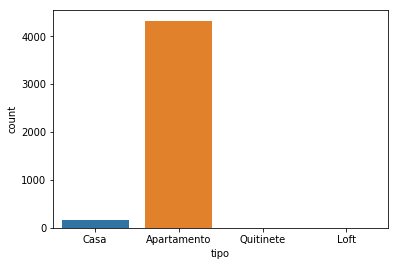

In [13]:
sns.countplot(x='tipo', data=train_set);
#plt.xticks(rotation=45);

In [14]:
replace_dict = {'Casa':0, 'Quitinete':0, 'Loft':0, 'Apartamento': 1}

train_set['tipo'] = train_set['tipo'].replace(replace_dict)
test_set['tipo'] = test_set['tipo'].replace(replace_dict)

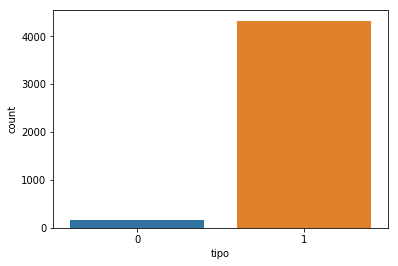

In [15]:
sns.countplot(x='tipo', data=train_set);

In [16]:
print ('Train shape: ', train_set.shape)
print ('Test shape: ', test_set.shape)

Train shape:  (4484, 21)
Test shape:  (2000, 20)


#### 3.1.2 Bairro

Pela do bairro, podemos ver que temos 66 bairros diferentes sendo que o bairro mais frequente é Boa Viagem (1599 ocorrências). Como esta variável deve ser binarizada, ela sozinha geraria 66 variáveis a mais para o modelo, todas informando apenas qual bairro o imóvel se encontra. 

Para reduzir o número de variáveis, traçaremos um threshold definindo os bairros que não possuem quantidade expressiva de ocorrências. 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]),
 <a list of 66 Text xticklabel objects>)

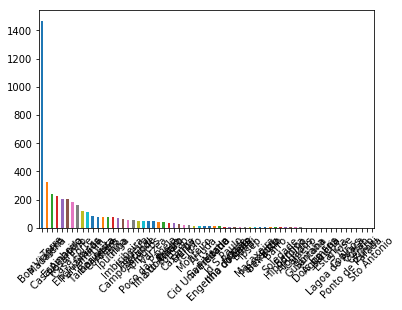

In [17]:
train_set['bairro'].value_counts().plot(kind="bar")
plt.xticks(rotation=45)

#### Clusterização dos bairros

In [18]:
df_train_bairros = pd.get_dummies(train_set['bairro'], prefix='bairro')
df_test_bairros = pd.get_dummies(test_set['bairro'], prefix='bairro')

In [19]:
# Making sure test set has all columns of train set except for preco
for column in df_train_bairros.columns:
    if column not in df_test_bairros.columns and column != 'preco':
        df_test_bairros[column] = 0

for column in df_test_bairros.columns:
    if column not in df_train_bairros.columns:
        df_train_bairros[column] = 0

In [20]:
df_train_bairros['preco'] = train_set['preco']

In [21]:
from sklearn.cluster import KMeans 
n_clusters = 30

kmeans = KMeans(n_clusters = n_clusters, random_state = 0)
kmeans.fit(df_train_bairros.drop(['preco'], axis = 1), df_train_bairros['preco'])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=30, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [22]:
df_train_clusters = pd.DataFrame()
df_train_clusters['clusters'] = kmeans.labels_
df_train_clusters['preco'] = df_train_bairros['preco']

In [23]:
train_set['bairro'] = kmeans.predict(df_train_bairros.drop(['preco'], axis = 1))
test_set['bairro'] = kmeans.predict(df_test_bairros)

In [24]:
train_set = pd.concat([train_set, pd.get_dummies(train_set['bairro'], prefix='bairro')], axis=1)
train_set.drop(['bairro'], axis = 1, inplace = True)
test_set = pd.concat([test_set, pd.get_dummies(test_set['bairro'], prefix='bairro')], axis=1)
test_set.drop(['bairro'], axis = 1, inplace = True)

In [25]:
# Making sure test set has all columns of train set except for preco
for column in train_set.columns:
    if column not in test_set.columns and column != 'preco':
        test_set[column] = 0

for column in test_set.columns:
    if column not in train_set.columns:
        train_set[column] = 0

In [26]:
print ('Train shape: ', train_set.shape)
print ('Test shape: ', test_set.shape)

Train shape:  (4484, 50)
Test shape:  (2000, 49)


#### 3.1.3 Tipo Vendedor
Como só há 2 tipos de vendedores (Imobiliária e Pessoa Física), categorizaremos essa variável da seguinte forma: 
- 0: Imobiliária
- 1: Pessoa Física

(array([0, 1]), <a list of 2 Text xticklabel objects>)

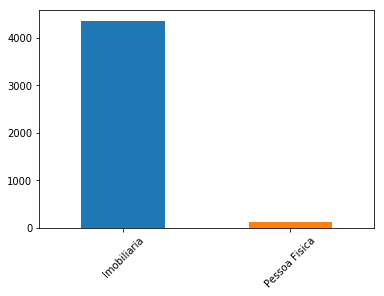

In [27]:
train_set['tipo_vendedor'].value_counts().plot(kind="bar")
plt.xticks(rotation=45)

In [28]:
replace_dict = {'Imobiliaria':0, 'Pessoa Fisica': 1}

train_set['tipo_vendedor'] = train_set['tipo_vendedor'].replace(replace_dict)
test_set['tipo_vendedor'] = test_set['tipo_vendedor'].replace(replace_dict)

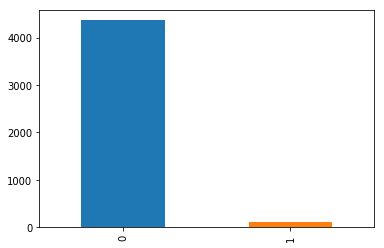

In [29]:
train_set['tipo_vendedor'].value_counts().plot(kind="bar")

#### 3.1.4 Diferenciais
O campo diferenciais possui itens separados por **e**. Assim, separaremos esses itens em colunas indicando quais itens o imóvel tem. Note que, se o item já estiver na lista de itens binarizados, ou seja, os que já vieram como variáveis numéricas binárias, este item não será um diferencial extra pois esta informação já está contida no dataset

In [30]:
itens_binarizados = ['churrasqueira', 'estacionamento', 'piscina', 
             'playground', 'quadra', 's_festas', 
             's_jogos', 's_ginastica', 'sauna', 'vista_mar']

In [31]:
separador_diferenciais = lambda x: pd.Series([str(i).lower() for i in reversed(x.split(' e '))])
diferenciais = train_set['diferenciais'].apply(separador_diferenciais)

In [32]:
diferenciais_unicos = np.array([])
for dif_index in diferenciais.columns:
    diferenciais_unicos = np.append(diferenciais_unicos, diferenciais[dif_index].unique(), axis = 0)        
diferenciais_unicos = np.array(['nenhum' if x is np.nan else x for x in diferenciais_unicos])
diferenciais_unicos = np.unique(diferenciais_unicos)

In [33]:
for diferencial in diferenciais_unicos:
    if diferencial not in itens_binarizados:
        train_set['dif_' + str(diferencial)] = train_set['diferenciais'].apply(lambda x: 1 if diferencial in x else 0)
        test_set['dif_' + str(diferencial)] = test_set['diferenciais'].apply(lambda x: 1 if diferencial in x else 0)
train_set.drop(['diferenciais'], axis = 1, inplace = True)
test_set.drop(['diferenciais'], axis = 1, inplace = True)

In [34]:
print ('Train shape: ', train_set.shape)
print ('Test shape: ', test_set.shape)

Train shape:  (4484, 63)
Test shape:  (2000, 62)


### 3.2 Transformação Variáveis Numéricas Não-Binárias

quartos, suites, vagas, area_util, area_extra

In [35]:
numerical_colnames = ['quartos', 'suites', 'vagas', 'area_util', 'area_extra']
train_set[numerical_colnames].describe()

,quartos,suites,vagas,area_util,area_extra
count,4484.000000,4484.000000,4484.000000,4484.000000,4484.000000
mean,2.994871,1.342774,1.626004,115.011597,12.081624
std,0.842609,1.004136,1.116043,93.499309,270.562942
min,1.000000,0.000000,0.000000,21.000000,0.000000
25%,3.000000,1.000000,1.000000,67.000000,0.000000
50%,3.000000,1.000000,1.000000,92.000000,0.000000
75%,4.000000,2.000000,2.000000,139.000000,0.000000
max,9.000000,6.000000,30.000000,2045.000000,17450.000000


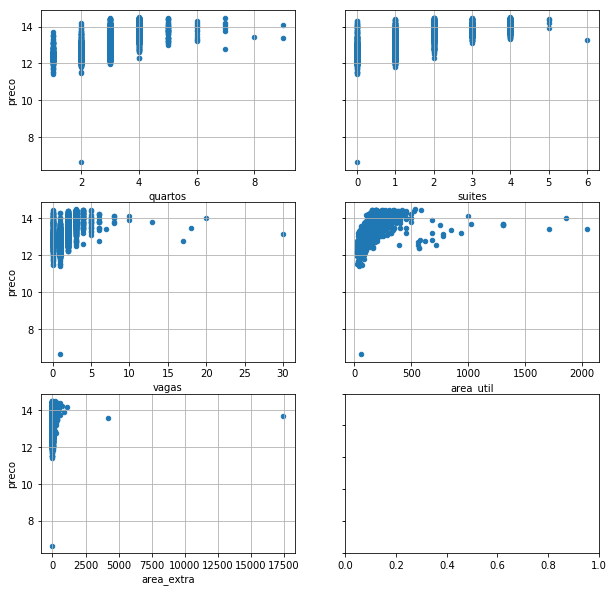

In [36]:
data = pd.concat([train_set['preco'], train_set[numerical_colnames]], axis=1)
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
for i in range(len(numerical_colnames)):
    data.plot.scatter(x = numerical_colnames[i], y = 'preco', ax = axes[i//2, i%2], 
                      sharey = True, grid = True)

#### 3.2.1 Quartos

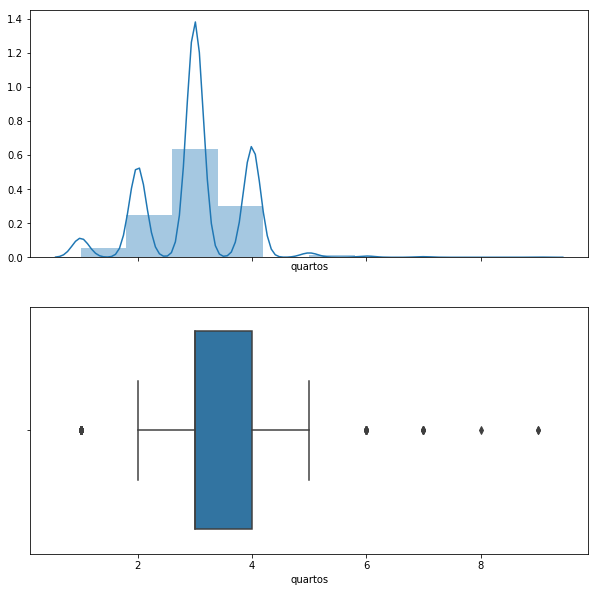

In [38]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
sns.distplot(train_set['quartos'], bins = 10, ax = axes[0])
sns.boxplot(x = train_set['quartos'], ax = axes[1])

In [39]:
quartos_thr = 6
train_set = train_set[train_set['quartos'] < quartos_thr]

In [40]:
print ('Train shape: ', train_set.shape)
print ('Test shape: ', test_set.shape)

Train shape:  (4463, 63)
Test shape:  (2000, 62)


#### 3.3.2 Suites

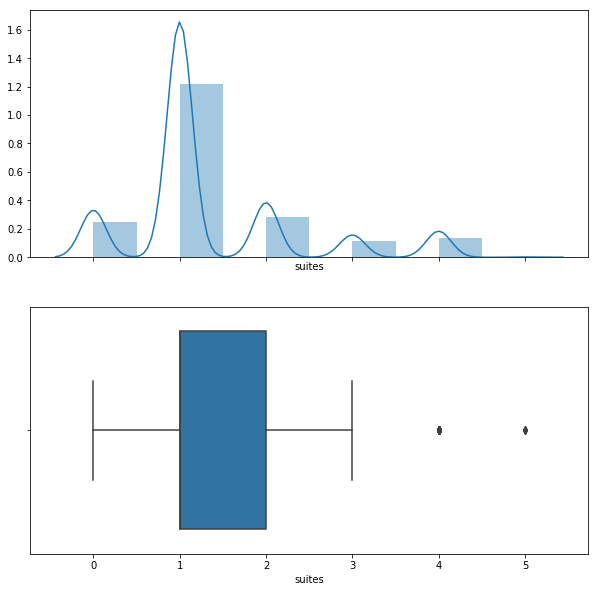

In [41]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
sns.distplot(train_set['suites'], bins = 10, ax = axes[0])
sns.boxplot(x = train_set['suites'], ax = axes[1])

In [42]:
suites_thr = 4
train_set = train_set[train_set['suites'] < suites_thr]

In [43]:
print ('Train shape: ', train_set.shape)
print ('Test shape: ', test_set.shape)

Train shape:  (4158, 63)
Test shape:  (2000, 62)


#### 3.3.3 Vagas

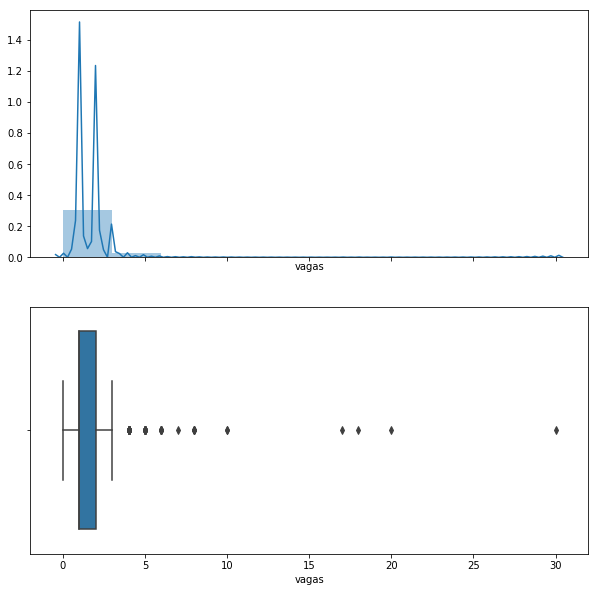

In [44]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
sns.distplot(train_set['vagas'], bins = 10, ax = axes[0])
sns.boxplot(x = train_set['vagas'], ax = axes[1])

In [45]:
vagas_thr = 11
train_set = train_set[train_set['vagas'] < vagas_thr]

In [46]:
print ('Train shape: ', train_set.shape)
print ('Test shape: ', test_set.shape)

Train shape:  (4154, 63)
Test shape:  (2000, 62)


#### 3.3.4 Area Util

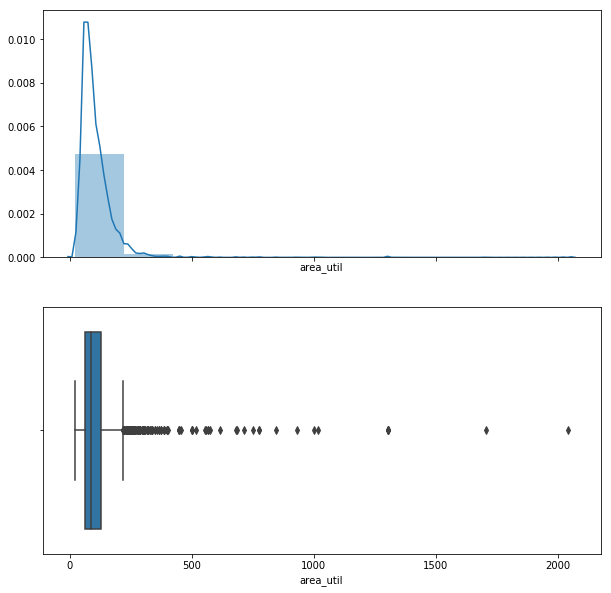

In [47]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
sns.distplot(train_set['area_util'], bins = 10, ax = axes[0])
sns.boxplot(x = train_set['area_util'], ax = axes[1])

In [48]:
area_util_thr = 500
train_set = train_set[train_set['area_util'] < area_util_thr]

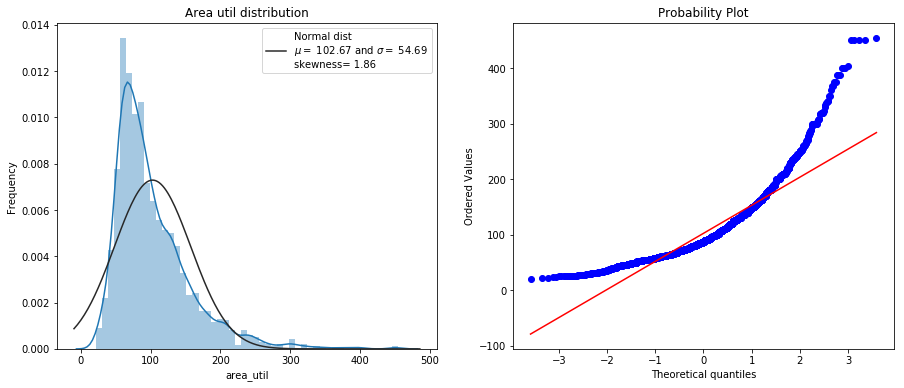

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.distplot(train_set['area_util'], fit = norm, ax = axes[0]);

(mu, sigma) = norm.fit(train_set['area_util'])
axes[0].legend(['Normal dist \n$\mu=$ {:.2f} and $\sigma=$ {:.2f}\nskewness= {:.2f}'
                                                .format(mu, sigma, skew(train_set['area_util']))],
               loc='best')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Area util distribution')

res = stats.probplot(train_set['area_util'], plot = axes[1])
plt.show()

In [50]:
train_set['area_util'] = np.log1p(train_set['area_util'])
test_set['area_util'] = np.log1p(test_set['area_util'])

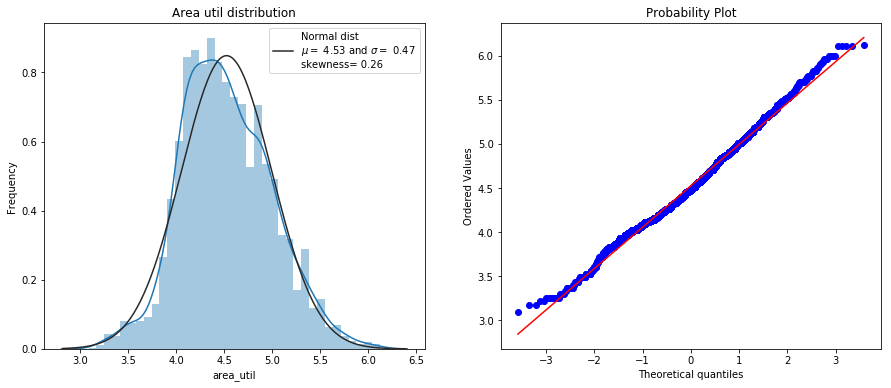

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.distplot(train_set['area_util'], fit = norm, ax = axes[0]);

(mu, sigma) = norm.fit(train_set['area_util'])
axes[0].legend(['Normal dist \n$\mu=$ {:.2f} and $\sigma=$ {:.2f}\nskewness= {:.2f}'
                                                .format(mu, sigma, skew(train_set['area_util']))],
               loc='best')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Area util distribution')

res = stats.probplot(train_set['area_util'], plot = axes[1])
plt.show()

In [52]:
print ('Train shape: ', train_set.shape)
print ('Test shape: ', test_set.shape)

Train shape:  (4128, 63)
Test shape:  (2000, 62)


#### 3.3.5 Area Extra

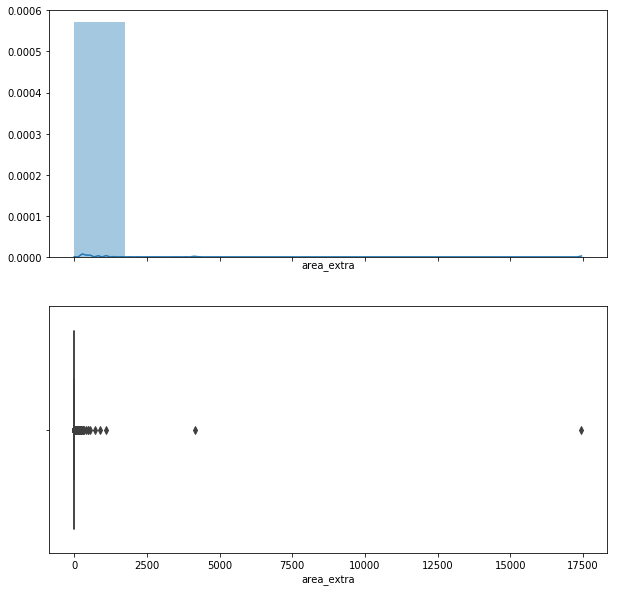

In [53]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
sns.distplot(train_set['area_extra'], bins = 10, ax = axes[0])
sns.boxplot(x = train_set['area_extra'], ax = axes[1])

In [54]:
area_extra_thr = 1000
train_set = train_set[train_set['area_extra'] < area_extra_thr]

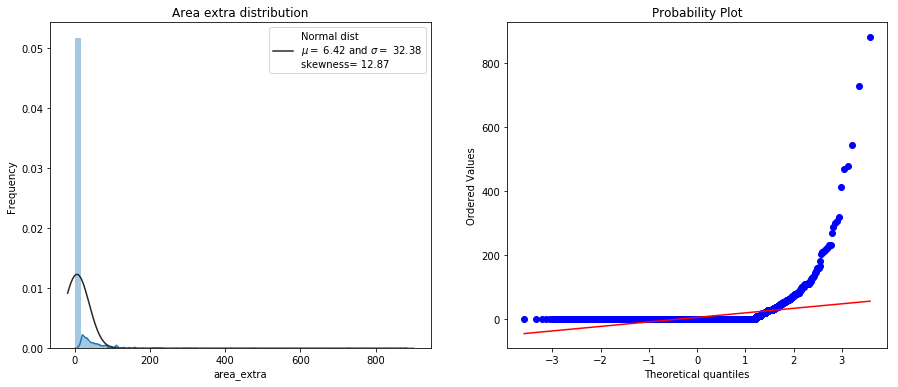

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.distplot(train_set['area_extra'], fit = norm, ax = axes[0]);

(mu, sigma) = norm.fit(train_set['area_extra'])
axes[0].legend(['Normal dist \n$\mu=$ {:.2f} and $\sigma=$ {:.2f}\nskewness= {:.2f}'
                                                .format(mu, sigma, skew(train_set['area_extra']))],
               loc='best')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Area extra distribution')

res = stats.probplot(train_set['area_extra'], plot = axes[1])
plt.show()

In [56]:
train_set['area_extra'] = np.log1p(train_set['area_extra'])
test_set['area_extra'] = np.log1p(test_set['area_extra'])

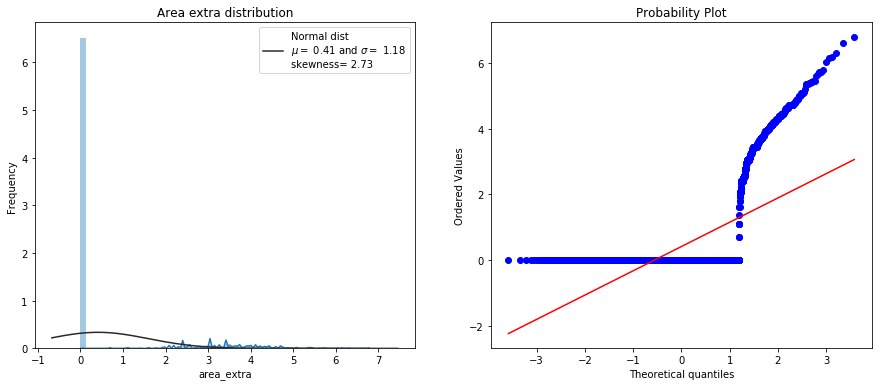

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.distplot(train_set['area_extra'], fit = norm, ax = axes[0]);

(mu, sigma) = norm.fit(train_set['area_extra'])
axes[0].legend(['Normal dist \n$\mu=$ {:.2f} and $\sigma=$ {:.2f}\nskewness= {:.2f}'
                                                .format(mu, sigma, skew(train_set['area_extra']))],
               loc='best')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Area extra distribution')

res = stats.probplot(train_set['area_extra'], plot = axes[1])
plt.show()

In [58]:
numerical_colnames = ['quartos', 'suites', 'vagas', 'area_util', 'area_extra']
train_set[numerical_colnames].describe()

,quartos,suites,vagas,area_util,area_extra
count,4125.000000,4125.000000,4125.000000,4125.000000,4125.000000
mean,2.899152,1.143030,1.504000,4.525734,0.412201
std,0.777042,0.713527,0.824748,0.469990,1.182127
min,1.000000,0.000000,0.000000,3.091042,0.000000
25%,2.000000,1.000000,1.000000,4.189655,0.000000
50%,3.000000,1.000000,1.000000,4.477337,0.000000
75%,3.000000,1.000000,2.000000,4.852030,0.000000
max,5.000000,3.000000,10.000000,6.122493,6.783325


### 3.4 Transformação Variáveis Numéricas Binárias

### 3.5 Analisando Correlação entre Variáveis

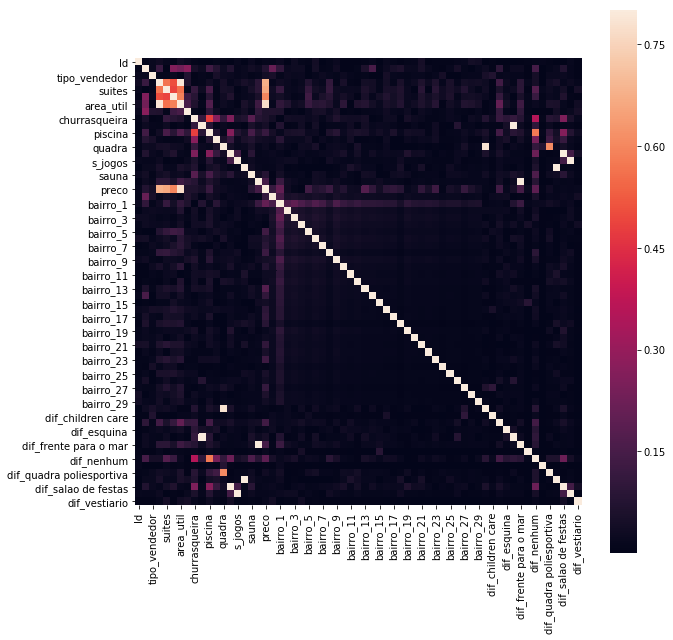

In [59]:
corrmat = abs(train_set.corr())
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corrmat, vmax=.8, square=True)

Como há muitas variáveis até o momento, filtraremos as variáveis cuja correlação está acima de um threshold determinado. 

In [60]:
corr = train_set.corr()
column_names = []
columns = corr.columns
corr_thr = 0.6
for column in columns:
    for row in columns:        
        if column != row and np.abs(corr[column][row]) > corr_thr:            
            if column not in column_names:
                column_names.append(column)
            if row not in column_names:
                column_names.append(row)
column_names.append('preco')

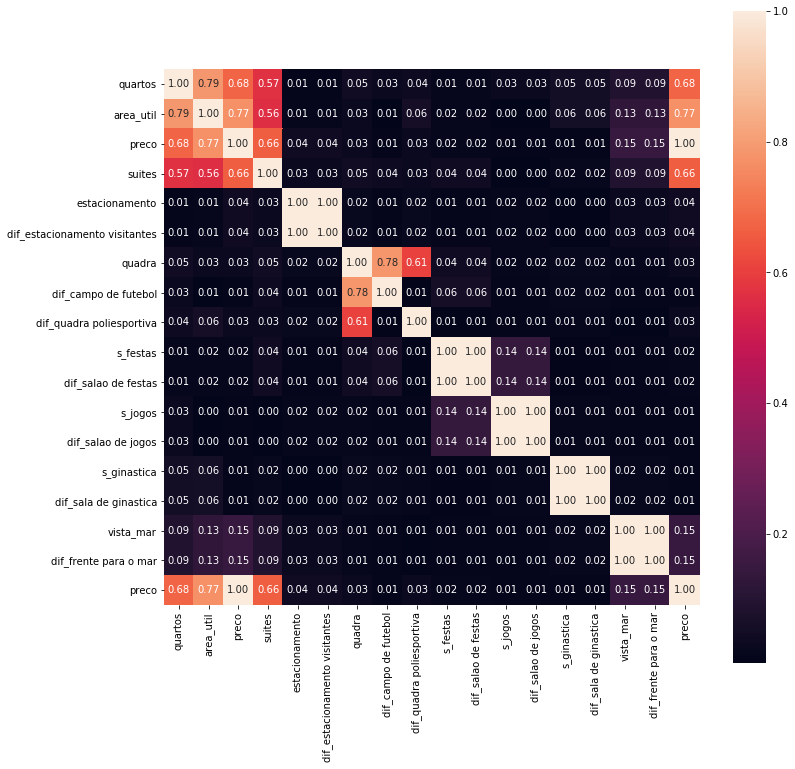

In [61]:
features = column_names
fig, ax = plt.subplots(figsize=(12,12))
corrmat = abs(train_set[features].corr())
cm = abs(np.corrcoef(train_set[features].values.T))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', 
                 annot_kws={'size': 10}, yticklabels=features, 
                 xticklabels=features)

- As variáveis **quartos** e **suites** parecem ter uma alta correlação entre si. No entanto, a variável quartos possui uma maior correlação com a variável preço. Portanto, removeremos a variável **suites**.
- As variáveis **estacionamento** e **dif_estacionamento visitantes** estão redundantes
- As variáveis **quadra**, **dif_campo_de_futebol** e **dif_quadra_poliesportiva** possuem alta correlação entre si. Como a variável **dif_quadra_poliesportiva** é a que possui a maior correlação com a variável de saída **preço**, ela será mantida.
- As variáveis **s_festas** e **dif_salao de festas** são redundantes.
- As variáveis **s_jogos** e **dif_salao de jogos** são redundantes.
- As variáveis **s_ginastica** e **dif_sala de ginastica** são redundantes.
- As variáveis **vista_mar** e **dif_frente para o mar** são redundantes.

In [62]:
drop_by_correlation = ['suites', 'dif_estacionamento visitantes', 'dif_quadra poliesportiva', 'dif_salao de festas', 'dif_sala de ginastica', 'dif_frente para o mar']
train_set.drop(drop_by_correlation, axis = 1, inplace = True)
test_set.drop(drop_by_correlation, axis = 1, inplace = True)

In [63]:
print ('Train shape: ', train_set.shape)
print ('Test shape: ', test_set.shape)

Train shape:  (4125, 57)
Test shape:  (2000, 56)


In [64]:
train_set.drop(['Id'], axis = 1).describe()

,tipo,tipo_vendedor,quartos,vagas,area_util,area_extra,churrasqueira,estacionamento,piscina,playground,...,bairro_29,dif_campo de futebol,dif_children care,dif_copa,dif_esquina,dif_hidromassagem,dif_nenhum,dif_quadra de squash,dif_salao de jogos,dif_vestiario
count,4125.000000,4125.000000,4125.000000,4125.000000,4125.000000,4125.000000,4125.000000,4125.000000,4125.000000,4125.000000,...,4125.000000,4125.000000,4125.000000,4125.000000,4125.000000,4125.000000,4125.000000,4125.000000,4125.000000,4125.000000
mean,0.968485,0.027394,2.899152,1.504000,4.525734,0.412201,0.305697,0.032242,0.540606,0.166061,...,0.007758,0.024242,0.001455,0.063273,0.023515,0.000485,0.220848,0.000242,0.007273,0.000727
std,0.174726,0.163248,0.777042,0.824748,0.469990,1.182127,0.460758,0.176665,0.498409,0.372180,...,0.087745,0.153820,0.038115,0.243482,0.151551,0.022017,0.414869,0.015570,0.084980,0.026961
min,0.000000,0.000000,1.000000,0.000000,3.091042,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,2.000000,1.000000,4.189655,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,3.000000,1.000000,4.477337,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,3.000000,2.000000,4.852030,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,5.000000,10.000000,6.122493,6.783325,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


##  4. Treinamento dos Modelos

In [65]:
train_feat = train_set.drop(['preco', 'Id'], axis = 1)
test_feat = test_set.drop(['Id'], axis = 1)
target = train_set['preco']

In [66]:
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline

In [219]:
x_scaler = RobustScaler()
y_scaler = RobustScaler()

x = x_scaler.fit_transform(train_feat)
x_test = x_scaler.transform(test_feat)
y = y_scaler.fit_transform(target.values.reshape(-1, 1))

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.25)

results = pd.DataFrame([], columns = ['mean', 'std'])
model_predictions = pd.DataFrame()
model_predictions_test = pd.DataFrame()

In [68]:
%%time
n_folds = 5

def rmsle_cv(model, features, target, n_folds = 1):
    kf = KFold(n_folds, shuffle=True).get_n_splits(features.values)
    rmse= np.sqrt(-cross_val_score(model, features.values, target, #target.values.reshape(-1, 1), 
                                   scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

Wall time: 0 ns


### Linear Regression

In [69]:
%%time
from sklearn.linear_model import LinearRegression
model_linearRegression = LinearRegression()
linreg = make_pipeline(RobustScaler(), model_linearRegression)
score = rmsle_cv(linreg, train_feat, target.values.reshape(-1, 1), n_folds)
results.loc['LinReg'] = [score.mean(), score.std()]

Wall time: 130 ms


In [220]:
%%time
model_linearRegression.fit(train_feat, target.values.reshape(-1, 1))
model_predictions['linreg'] = model_linearRegression.predict(train_feat).ravel()
model_predictions_test['linreg'] = model_linearRegression.predict(test_feat).ravel()


Wall time: 11 ms


### Lasso Regression

In [89]:
%%time
from sklearn.linear_model import Lasso
model_lasso = Lasso(alpha =0.0005)
lasso = make_pipeline(RobustScaler(), model_lasso)
score = rmsle_cv(lasso, train_feat, target.values.reshape(-1, 1), n_folds)
results.loc['lasso'] = [score.mean(), score.std()]

Wall time: 102 ms


In [221]:
%%time
model_lasso.fit(train_feat, target.values.reshape(-1, 1))
model_predictions['lasso'] = model_lasso.predict(train_feat).ravel()
model_predictions_test['lasso'] = model_lasso.predict(test_feat).ravel()

Wall time: 17 ms


### Passive Agressive Regression
Dependente da inicialização

In [93]:
%%time
from sklearn.linear_model import PassiveAggressiveRegressor
model_passagr = PassiveAggressiveRegressor(C = 1.0, max_iter = 5, tol = None)
passagr = make_pipeline(RobustScaler(), model_passagr)
score = rmsle_cv(passagr, train_feat, target.values, n_folds)
results.loc['PassiveAgressive'] = [score.mean(), score.std()]

Wall time: 103 ms


In [222]:
%%time
model_passagr.fit(train_feat, target.values)
model_predictions['passiveAgressive'] = model_passagr.predict(train_feat).ravel()
model_predictions_test['passiveAgressive'] = model_passagr.predict(test_feat).ravel()

Wall time: 11.9 ms


### Elastic Net

In [97]:
%%time
from sklearn.linear_model import ElasticNet
model_elasticNet = ElasticNet(alpha=0.0005, l1_ratio=.9)
elasticNet = make_pipeline(RobustScaler(), model_elasticNet)
score = rmsle_cv(elasticNet, train_feat, target.values, n_folds)
results.loc['ElasticNet'] = [score.mean(), score.std()]

Wall time: 175 ms


In [223]:
%%time
model_elasticNet.fit(train_feat, target.values)
model_predictions['ElasticNet'] = model_elasticNet.predict(train_feat).ravel()
model_predictions_test['ElasticNet'] = model_elasticNet.predict(test_feat).ravel()

Wall time: 32.9 ms


### Kernel Ridge Regression

In [99]:
%%time
from sklearn.kernel_ridge import KernelRidge

model_KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
score = rmsle_cv(model_KRR, train_feat, target.values, n_folds)
results.loc['KRR'] = [score.mean(), score.std()]

Wall time: 2.33 s


In [224]:
%%time
model_KRR.fit(train_feat, target.values)
model_predictions['KRR'] = model_KRR.predict(train_feat).ravel()
model_predictions_test['KRR'] = model_KRR.predict(test_feat).ravel()

Wall time: 971 ms


### Gradient Boost

In [101]:
%%time
from sklearn.ensemble import GradientBoostingRegressor

model_GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber')
score = rmsle_cv(model_GBoost, train_feat, target.values, n_folds)
results.loc['GBoost'] = [score.mean(), score.std()]

Wall time: 31.3 s


In [225]:
%%time
model_GBoost.fit(train_feat, target.values)
model_predictions['GBoost'] = model_GBoost.predict(train_feat).ravel()
model_predictions_test['GBoost'] = model_GBoost.predict(test_feat).ravel()

Wall time: 7.76 s


### XGBoost

In [227]:
%%time
import xgboost as xgb

model_XGB = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
score = rmsle_cv(model_XGB, train_feat, target.values, n_folds)
results.loc['XGB'] = [score.mean(), score.std()]

Wall time: 21.8 s


In [246]:
%%time
model_XGB.fit(np.array(train_feat), target.values)
model_predictions['XGB'] = model_XGB.predict(np.array(train_feat)).ravel()
model_predictions_test['XGB'] = model_XGB.predict(np.array(test_feat)).ravel()

Wall time: 4.92 s


### LGBoost

In [106]:
%%time
import lightgbm as lgb

model_LGB = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
score = rmsle_cv(model_LGB, train_feat, target.values, n_folds)
results.loc['LGB'] = [score.mean(), score.std()]

Wall time: 883 ms


In [229]:
%%time
model_LGB.fit(train_feat, target.values)
model_predictions['LGB'] = model_LGB.predict(train_feat).ravel()
model_predictions_test['LGB'] = model_LGB.predict(test_feat).ravel()

Wall time: 241 ms


### Bayesian Ridge

In [108]:
%%time
from sklearn.linear_model import BayesianRidge

model_BayRidge = BayesianRidge()
score = rmsle_cv(model_BayRidge, train_feat, target.values, n_folds)
results.loc['BayRidge'] = [score.mean(), score.std()]

Wall time: 71.8 ms


In [230]:
%%time
model_BayRidge.fit(train_feat, target.values)
model_predictions['BayRidge'] = model_BayRidge.predict(train_feat).ravel()
model_predictions_test['BayRidge'] = model_BayRidge.predict(test_feat).ravel()

Wall time: 16 ms


### Support Vector Regression

In [110]:
%%time
from sklearn.svm import SVR

model_svr = SVR(kernel='rbf', degree=3, gamma='auto', coef0=0.0, 
          tol=0.001, C=1.0, epsilon=0.1, shrinking=True, 
          cache_size=200, verbose=False, max_iter=-1)
score = rmsle_cv(model_svr, train_feat, target.values, n_folds)
results.loc['SVR'] = [score.mean(), score.std()]

Wall time: 3.45 s


In [231]:
%%time
model_svr.fit(train_feat, target.values)
model_predictions['SVR'] = model_svr.predict(train_feat).ravel()
model_predictions_test['SVR'] = model_svr.predict(test_feat).ravel()

Wall time: 1.79 s


### Random Forest Regressor

In [112]:
%%time
from sklearn.ensemble import RandomForestRegressor

model_RFR = RandomForestRegressor(n_estimators = 100)
score = rmsle_cv(model_RFR, train_feat, target.values, n_folds)
results.loc['RandomForest'] = [score.mean(), score.std()]

Wall time: 5.22 s


In [232]:
%%time
model_RFR.fit(train_feat, target.values)
model_predictions['RandomForest'] = model_RFR.predict(train_feat).ravel()
model_predictions_test['RandomForest'] = model_RFR.predict(test_feat).ravel()

Wall time: 1.44 s


### Perceptron

In [163]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import backend as K


In [134]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [170]:
history = model_perceptron.fit(train_feat, target, epochs = 1000, 
                              validation_split = 0.25, verbose = 0, 
                              callbacks = [early_stopping])

In [165]:
history.history.keys()

dict_keys(['val_loss', 'val_root_mean_squared_error', 'loss', 'root_mean_squared_error'])

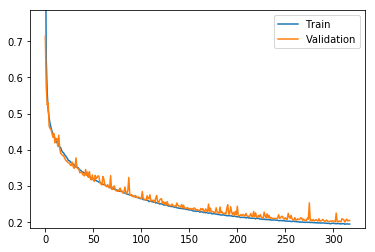

In [167]:
plt.plot(history.history['root_mean_squared_error'], label = 'Train')
plt.plot(history.history['val_root_mean_squared_error'], label = 'Validation')
plt.ylim(0.95*min(min(history.history['root_mean_squared_error']), min(history.history['val_root_mean_squared_error'])), 
         1.1*max(history.history['val_root_mean_squared_error']))
plt.legend()
plt.show()

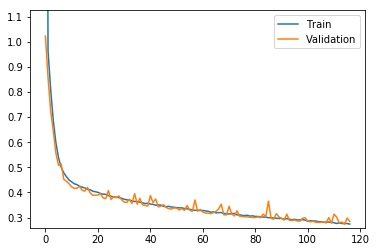

In [162]:
plt.plot(history.history['loss'], label = 'Train')
plt.plot(history.history['val_loss'], label = 'Validation')
plt.ylim(0.95*min(min(history.history['loss']), min(history.history['val_loss'])), 
         1.1*max(history.history['val_loss']))
plt.legend()
plt.show()

In [193]:
%%time
from sklearn.model_selection import KFold

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# define 10-fold cross validation test harness
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
cvscores = []
for train, val in kfold.split(train_feat, target):
  # create model
    model_perceptron = Sequential([Dense(1, activation = 'linear', input_dim = train_feat.shape[1])])
    model_perceptron.compile(optimizer='sgd', loss='mse', metrics = [root_mean_squared_error])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    
    # Fit the model
    model_perceptron.fit(train_feat.iloc[train], target.iloc[train], epochs = 1000, 
                              validation_split = 0.25, verbose = 0, 
                              callbacks = [early_stopping])
    # evaluate the model
    scores = model_perceptron.evaluate(train_feat.iloc[val], target.iloc[val], verbose=0)
    print("%s: %.6f" % (model_perceptron.metrics_names[1], scores[1]))
    cvscores.append(scores[1])
print("%.6f (+/- %.6f)" % (np.mean(cvscores), np.std(cvscores)))

root_mean_squared_error: 21.17%
root_mean_squared_error: 20.89%
root_mean_squared_error: 20.99%
root_mean_squared_error: 20.90%
root_mean_squared_error: 20.28%
0.21 (+/- 0.00)
Wall time: 1min 26s


In [197]:
results.loc['Perceptron'] = [np.mean(cvscores), np.std(cvscores)]

In [233]:
model_predictions['Perceptron'] = model_perceptron.predict(train_feat).ravel()
model_predictions_test['Perceptron'] = model_perceptron.predict(test_feat).ravel()

In [234]:
results.sort_values(by = 'mean')

,mean,std
XGB,0.240963,0.027683


### Ensemble

In [202]:
model_predictions.head()

,linreg,lasso,passiveAgressive,KRR,GBoost,ElasticNet,LGB,BayRidge,SVR,RandomForest,Perceptron
0,13.797607,13.838289,13.835021,13.846403,13.791667,13.835021,13.890354,13.807148,13.907840,13.839677,13.792936
1,12.409180,12.414006,12.413270,12.410552,12.868515,12.413270,12.676044,12.407033,12.527120,12.923408,12.283480
2,13.708923,13.713384,13.713058,13.746355,13.840263,13.713058,13.799682,13.710627,13.736028,13.847878,13.661581
3,12.809570,12.786631,12.787958,12.791263,12.809498,12.787958,12.797212,12.799860,12.778298,12.777189,12.702181
4,13.018921,13.099821,13.094318,13.019116,12.983097,13.094318,13.005484,13.037411,12.984605,13.020787,12.932554


In [206]:
model_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4125 entries, 0 to 4124
Data columns (total 11 columns):
linreg              4125 non-null float64
lasso               4125 non-null float64
passiveAgressive    4125 non-null float64
KRR                 4125 non-null float64
GBoost              4125 non-null float64
ElasticNet          4125 non-null float64
LGB                 4125 non-null float64
BayRidge            4125 non-null float64
SVR                 4125 non-null float64
RandomForest        4125 non-null float64
Perceptron          4125 non-null float32
dtypes: float32(1), float64(10)
memory usage: 338.5 KB


In [209]:
%%time
from sklearn.ensemble import GradientBoostingRegressor

model_ensemble = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber')
score = rmsle_cv(model_ensemble, model_predictions, target.values, n_folds)
#results.loc['GBoost'] = [score.mean(), score.std()]

Wall time: 32.2 s


In [247]:
%%time
model_ensemble.fit(model_predictions, target.values)
ensemble_predictions = model_ensemble.predict(model_predictions_test).ravel()

Wall time: 7.73 s


## Submissão

In [253]:
submission = pd.DataFrame()
submission['Id'] = test_set['Id']

predictions = ensemble_predictions
final_predictions = np.expm1(predictions)# * neighborhood_test/100

submission['preco'] = final_predictions

submission.to_csv('submission.csv', index=False)

_________________

In [204]:
%%time
from sklearn.model_selection import KFold

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# define 10-fold cross validation test harness
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
cvscores = []
for train, val in kfold.split(model_predictions, target):
  # create model
    model_ensemble = Sequential([Dense(1, activation = 'linear', input_dim = model_predictions.shape[1])])
    model_ensemble.compile(optimizer='sgd', loss='mse', metrics = [root_mean_squared_error])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    
    # Fit the model
    model_ensemble.fit(model_predictions.iloc[train], target.iloc[train], epochs = 1000, 
                              validation_split = 0.25, verbose = 0, 
                              callbacks = [early_stopping])
    # evaluate the model
    scores = model_ensemble.evaluate(model_predictions.iloc[val], target.iloc[val], verbose=0)
    print("%s: %.6f" % (model_ensemble.metrics_names[1], scores[1]))
    cvscores.append(scores[1])
print("%.6f (+/- %.6f)" % (np.mean(cvscores), np.std(cvscores)))

C:\Anaconda\lib\site-packages\keras\callbacks.py:538: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):


root_mean_squared_error: nan
root_mean_squared_error: nan
root_mean_squared_error: nan
root_mean_squared_error: nan
root_mean_squared_error: nan
nan (+/- nan)
Wall time: 4.74 s


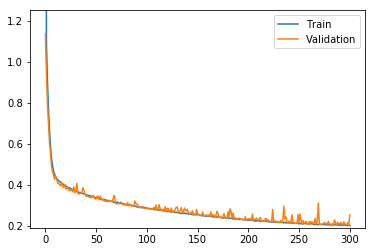

In [142]:
plt.plot(history.history['loss'], label = 'Train')
plt.plot(history.history['val_loss'], label = 'Validation')
plt.ylim(0.95*min(min(history.history['loss']), min(history.history['val_loss'])), 
         1.1*max(history.history['val_loss']))
plt.legend()
plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import backend as K

class Ensemble():
    def __init__(self, models):
        K.clear_session()
        self.models = models
        self.ensemble_model = Sequential([Dense(1, activation = 'linear', 
                                                input_dim = len(models))
                                         ])
        self.ensemble_model.compile(optimizer='sgd', loss='mse')
        self.early_stopping = EarlyStopping(monitor='val_loss', patience=10)
        self.x_scaler = RobustScaler()
        self.y_scaler = RobustScaler()
        
    def fit(self, x, y):
        x = self.x_scaler.fit_transform(x.values)
        y = self.y_scaler.fit_transform(y.values.reshape(-1, 1))
        predictions = []
        i = 0
        for split in KFold(len(self.models), shuffle=True).split(x):
            self.models[i].fit(x[split[0]], y[:, 0][split[0]])
            predictions.append(self.models[i].predict(x))
            i += 1
        predictions_reshape = [[]]*len(x)
        for i in range(len(x)):
            aux = [];
            for j in range(len(predictions)):
                aux.append(predictions[j][i])
            predictions_reshape[i] = aux
        predictions_reshape = np.array(predictions_reshape)

        history = self.ensemble_model.fit(predictions_reshape, y[:, 0], epochs = 1000, 
                                          validation_split = 0.25, verbose = 0, 
                                          callbacks = [self.early_stopping])
        plt.plot(history.history['loss'], label = 'Train')
        plt.plot(history.history['val_loss'], label = 'Validation')
        plt.ylim(0.95*min(min(history.history['loss']), min(history.history['val_loss'])), 
                 1.1*max(history.history['val_loss']))
        plt.legend()
        plt.show()
    
    def predict(self, x):
        x = self.x_scaler.transform(x.values)
        predictions = []
        for i in range(len(self.models)):
            predictions.append(self.models[i].predict(x))
        predictions_reshape = [[]]*len(x)
        for i in range(len(x)):
            aux = [];
            for j in range(len(predictions)):
                aux.append(predictions[j][i])
            predictions_reshape[i] = aux
        predictions_reshape = np.array(predictions_reshape)
        
        return y_scaler.inverse_transform(self.ensemble_model.predict(predictions_reshape))\
                       .reshape(1, -1)[0]

In [ ]:
models = [
    BayesianRidge(),
    Lasso(alpha =0.0005),
    ElasticNet(alpha=0.0005, l1_ratio=.9),
    lgb.LGBMRegressor(objective='regression',num_leaves=5,
                      learning_rate=0.05, n_estimators=720,
                      max_bin = 55, bagging_fraction = 0.8,
                      bagging_freq = 5, feature_fraction = 0.2319,
                      feature_fraction_seed=9, bagging_seed=9,
                      min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
]

ensemble = Ensemble(models)
ensemble.fit(train_feat, target)
predictions = ensemble.predict(train_feat)

plt.scatter(predictions, target)
plt.xlim(min(min(predictions), min(target)) - 0.15, 
         max(max(predictions), max(target)) + 0.15)
plt.ylim(min(min(predictions), min(target)) - 0.15, 
         max(max(predictions), max(target)) + 0.15)
print('Error: ' + str(np.sqrt(mean_squared_error(predictions, target))))